# Dictionary learning on a sequence of MRI images of a beating heart

![MRIUrl](https://www.mhvi.com/wp-content/uploads/2018/09/MRI-anim.gif "heart")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import time

from utils import *
from dictionary_learning import *
import optimal_transport

Import data: load $30$ gray scale images of size $283 \times 486$

Shape of Images: (30, 283, 486)


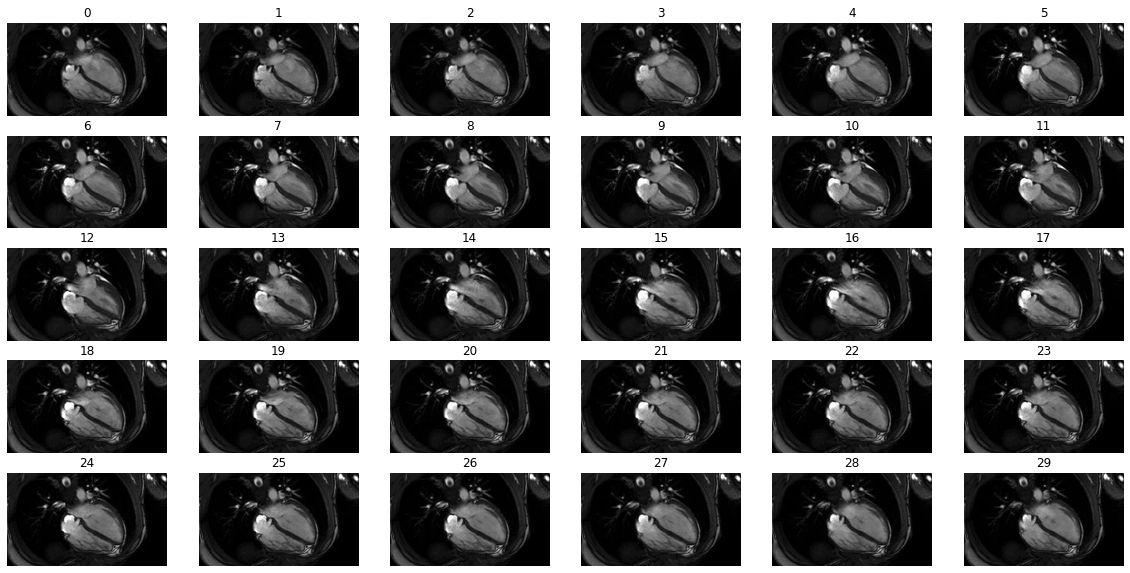

In [2]:
n = 30
x_length, y_length = 486, 283
Images = np.zeros((n, y_length, x_length))
print("Shape of Images:", Images.shape)

plt.figure(figsize=(20, 10))
for i in range(n):
    # load image as pixel array
    image = img.imread('mri_frames/frame_{:02d}_delay-0.03s.gif'.format(i))
    Images[i, :, :] = image[:, :, 0]
    plt.subplot(5, 6, i+1)
    plt.title(i)
    plt.imshow(image)
    plt.axis('off')

Turn images into point clouds:

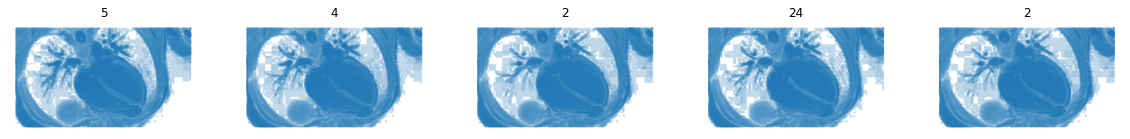

In [3]:
point_clouds, masses = {}, {}
np.random.seed(5)

# coordinates of the point clouds (we add a 'jittering' of epsilon to avoid pysdot issues)
idxes = np.where(Images[0]>=0)
cloud = np.zeros((len(idxes[0]), 2))
cloud[:, 0] = idxes[1]/(x_length-1)
cloud[:, 1] = 1 - idxes[0]/(y_length-1)
epsilon = np.random.normal(scale=1e-4, size=cloud.shape)
cloud += epsilon

# masses of the point clouds (pixel intensities)
for i in range(n):
    point_clouds[i] = cloud
    nu = Images[i][idxes]
    masses[i] = nu / np.sum(nu)
    
# visualize some point clouds
plt.figure(figsize=(20, 2))
for i in range(5):
    idx = np.random.randint(n)
    plt.subplot(1, 5, i+1)
    plt.scatter(cloud[:, 0], cloud[:, 1], s=1e3*masses[idx])
    plt.title(idx)
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.axis('off')
plt.show()

Compute transport plans (about half an hour):

In [4]:
grid_size = 1500
start = time.time()
heart_ot = optimal_transport.semi_discrete_ot(grid_size=grid_size)
heart_ot.fit_transport_plans(point_clouds, masses)
end = time.time()
print("Duration:", (end - start))
np.save('heart_transport_plan_grid_1500', heart_ot.transport_plans)
#X = np.load('mri_frames/heart_transport_plan_grid_1500.npy').T
print(X.shape)

(4500000, 30)


Define pushforward plot/operation for 2D images:

In [5]:
def push_forward(T, form='histogram', title=None, s=5e-5, bins=y_length//3, x_length=x_length, y_length=y_length,
                 hist_range=np.array([[0, 1], [0, 1]]), return_hist=False):
    # extract point cloud
    grid_size = np.int(np.sqrt(len(T)//2))
    point_cloud = np.reshape(T, (grid_size*grid_size, 2))
    # visualization as a point cloud
    if form=='point_cloud':
        plt.scatter(point_cloud[:, 0], point_cloud[:, 1], s)
        title_1 = 'Push forward as a point cloud' 
    # visualization as an histogram
    elif form=='histogram':
        histogram_2D = np.histogram2d(point_cloud[:, 0], point_cloud[:, 1],
                                      bins=np.array([int(x_length/y_length * bins), bins]),
                                      range=hist_range)
        histogram_2D = np.rot90(histogram_2D[0])/np.sum(histogram_2D[0])
        if return_hist:
            return histogram_2D
        else:
            plt.imshow(histogram_2D, cmap='gray')
            title_1 = 'Push forward as an histogram' 
    else:
        raise NameError("Error: 'form' should be one of 'point_cloud' or 'histogram'.")
    if title is not None:
        plt.title(title) 
    else:
        plt.title(title_1)
    plt.axis('off')

Observe push forward of transport plan and compare to original image:

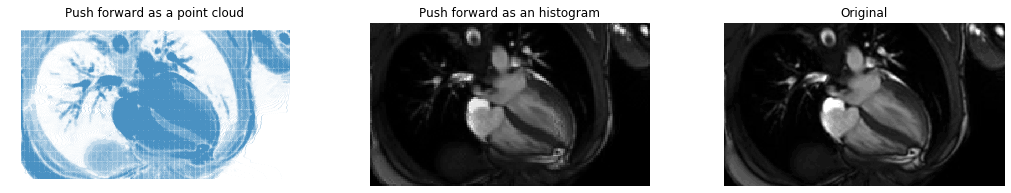

In [6]:
i = 9
bins = 120

plt.figure(figsize=(18, 3))

# push forward as point cloud
plt.subplot(1, 3, 1)
push_forward(X[:, i], form='point_cloud')

# push forward as an histogram
plt.subplot(1, 3, 2)
push_forward(X[:, i], form='histogram')

# original image
plt.subplot(1, 3, 3)
plt.imshow(Images[i, :, :], cmap='gray')
plt.title('Original')
plt.axis('off')

plt.show()

## Dictionary learning
Parameters:

In [7]:
(b, n) = X.shape
k = 4

Method to observe the learned atoms, the path of the codes in a 3D space and the reconstructed sequence of images:

In [8]:
def plot_atoms(D):
    plt.figure(figsize=(7, 5))
    for i in range(k):
        plt.subplot(2, k//2, i+1)
        push_forward(D[:, i], form='histogram', title='Atom {}'.format(i))

def plot_code_path(Lambda, axes=(0, 1, 2), angle=100):
    xs, ys, zs = Lambda[axes[0]], Lambda[axes[1]], Lambda[axes[2]]
    fig=plt.figure(figsize=(6, 4))
    ax=fig.add_subplot(111, projection='3d')
    ax.view_init(30, angle)
    ax.scatter(xs, ys, zs)
    ax.plot(xs, ys, zs)
    ax.set_xlabel(r'$(\Lambda_i)_1$')
    ax.set_ylabel(r'$(\Lambda_i)_2$')
    ax.set_zlabel(r'$(\Lambda_i)_3$')
    
def reconstruct_GIF(D, Lambda, gif_title):
    # reconstruct transport plans
    X_rec = D.dot(Lambda)
    # push forward to get images
    reconstructed_images = []
    for i in range(X_rec.shape[1]):
        rec_i = push_forward(X_rec[:, i], return_hist=True)
        reconstructed_images.append(Image.fromarray(np.uint8(rec_i/np.max(rec_i)*255)))
    # save as a GIF
    reconstructed_images[0].save(gif_title, save_all=True,
                                 append_images=reconstructed_images[1:],
                                 loop=0, duration=30)

### Block coordinate descent - Atoms in the data

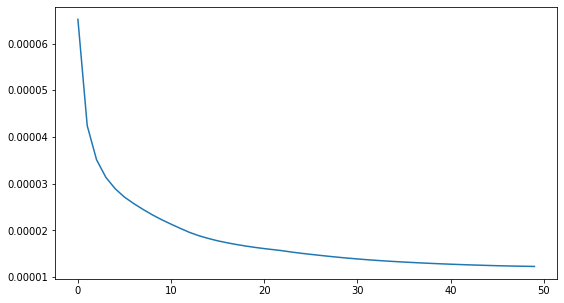

In [9]:
niter = 50 
step = 7e-6 

(b, n) = X.shape
k = 4

np.random.seed(1)

DL = DL_block_coordinate_descent(n, k)
DL.fit(X, niter, codes_in_simplex=True, atoms_in_data=True, step=step)
D = DL.D
Lambda = DL.Lambda

plt.figure(figsize=(9, 5))
plt.plot(np.arange(niter), DL.errors)

Observe atoms:

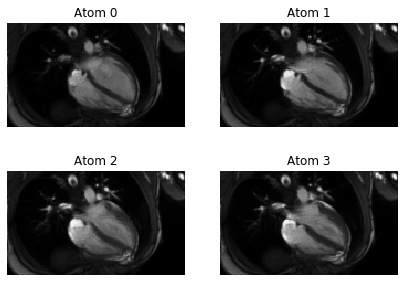

In [10]:
plot_atoms(D)
plt.savefig("outputs/atoms_cardiac_frames.pdf", bbox_inches="tight")

Observe some reconstructions:

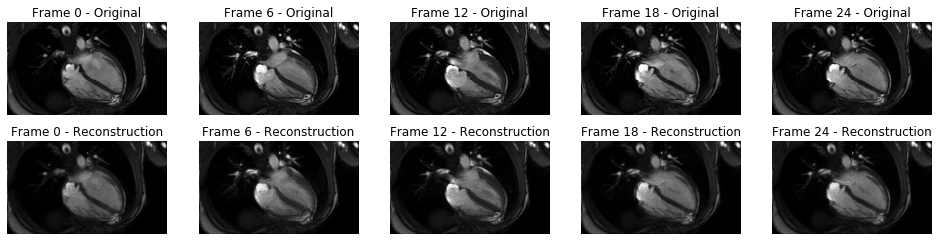

In [11]:
X_rec = D.dot(Lambda)

plt.figure(figsize=(20, 4))
for i in range(n//6):
    # load image as pixel array
    image = img.imread('mri_frames/frame_{:02d}_delay-0.03s.gif'.format(6*i))
    plt.subplot(2, 6, i+1)
    plt.title('Frame {} - Original'.format(6*i))
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(2, 6, i+7)
    rec = push_forward(X_rec[:, 6*i], return_hist=True)
    reconstructed_image = Image.fromarray(np.uint8(rec/np.max(rec)*255))
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title('Frame {} - Reconstruction'.format(6*i))
    plt.axis('off')
plt.savefig("outputs/example_cardiac_frames.pdf", bbox_inches="tight")

Observe code path:

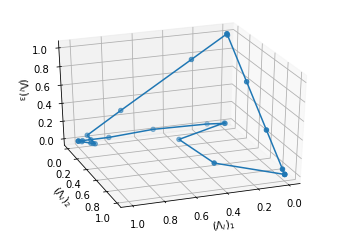

In [12]:
plot_code_path(Lambda, axes=(1, 2, 3), angle=70)
plt.savefig("outputs/cardiac_path.pdf", bbox_inches="tight")

Since we impose to have atoms in the data, we observe a code path that lies on the boudaries of the 3D simplex.

Observe reconstructed cycle:

In [13]:
reconstruct_GIF(D, Lambda, 'reconstructions/heart_sequence_reconstructed.gif')

**Reconstruction:**
<img src="reconstructions/heart_sequence_reconstructed.gif" width="400" height="790">

**Original:**
<img src="https://www.mhvi.com/wp-content/uploads/2018/09/MRI-anim.gif" width="400" height="790">